## Import all packages

In [41]:
import spacy
import json
import random
import re
import pandas as pd
import numpy as np
import os
import io
import matplotlib.pyplot as plt
import pickle
import fasttext
import srsly

from copy import deepcopy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.lang.en.examples import sentences 
from spacy.symbols import ORTH
from spacy.language import Language
from sklearn import model_selection
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from pprint import pprint
from joblib import dump, load

In [ ]:
from luima_sbd.sbd_utils import text2sentences

## Define setup() and analyze()

In [37]:
def setup():
    
    data_root = os.path.abspath(os.path.abspath(os.getcwd()))
    # load the embedding model files
    fasttext_root = os.path.join(data_root, 'model.bin')
    global model_1
    model_1 = fasttext.load_model(fasttext_root)
    # get best classifier model file path
    global best_model_path
    best_model_path = os.path.join(data_root,"clf_RF_embedding.joblib")


In [38]:
def analyze(string):
    
    def make_span_data(sentences, string):
        span_data = []
        for a in sentences:
            start = a[0]
            end = a[1]
            txt = string[a[0]:a[1]]
            sd = {'txt': txt,
                  'start': start,
                  'start_normalized': start / len(string),
                  'end': end}
            span_data.append(sd)
        return span_data

    def make_embedding_feature_vectors_and_labels(spans,fasttext_model):
        
        tokens = [s['tokens_spacy'] for s in spans]
        embedding = np.empty((len(spans),100), dtype='float32')
        for index_i, i in enumerate(tokens):
            for index_j, j in enumerate(i):
                if index_j == 0:
                    vector = fasttext_model.get_word_vector(j)
                else:
                    vector = vector + fasttext_model.get_word_vector(j)
            if len(i) >= 1:
                vector = vector/len(i)
            vector = np.expand_dims(vector, axis=0)
            embedding[index_i] = vector


        starts_normalized = np.array([s['start_normalized'] for s in spans])

        #normalized num_tokens
        num_tokens = np.array([len(s['tokens_spacy']) for s in spans])
        num_tokens = (num_tokens - np.mean(num_tokens))/(np.std(num_tokens)+1e-9)

        
        X = np.concatenate((embedding, np.expand_dims(starts_normalized, axis=1), np.expand_dims(num_tokens, axis=1)), axis=1)
        return X
    
    #use law-specific sentence segmentation
    sentences_index = text2sentences(string, offsets=True)
    
    
    spans = make_span_data(sentences_index, string)
    
    nlp = spacy.load("en_core_web_sm")
    nlp.disable_pipes('parser')
    nlp.tokenizer.add_special_case('post-traumatic', [{ORTH: 'post-traumatic'}])
    nlp.tokenizer.add_special_case('Dr.', [{ORTH: 'Dr.'}])
    nlp.tokenizer.add_special_case('Mr.', [{ORTH: 'Mr.'}])
    nlp.tokenizer.add_special_case('Jandreau v. Nicholson', [{ORTH: 'Jandreau v. Nicholson'}])
    nlp.tokenizer.add_special_case('x-ray', [{ORTH: 'x-ray'}])
    nlp.tokenizer.add_special_case('X-ray', [{ORTH: 'X-ray'}])
    nlp.tokenizer.add_special_case('X-Ray', [{ORTH: 'X-Ray'}])
    nlp.tokenizer.add_special_case('U.S.C.A.', [{ORTH: 'U.S.C.A.'}])
    nlp.tokenizer.add_special_case('Vet. App.', [{ORTH: 'Vet. App.'}])
    nlp.tokenizer.add_special_case('C.F.R.', [{ORTH: 'C.F.R.'}])
    nlp.tokenizer.add_special_case('Fed. Cir.', [{ORTH: 'Fed. Cir.'}])
    
    def spacy_tokenize(txt):
        doc = nlp(txt)
        tokens = list(doc)
        clean_tokens = []
    
        for t in tokens:
            if t.pos_ == 'PUNCT':
                pass
            elif t.lemma_ == "§" or t.lemma_ == "[" or t.lemma_ == "]" or t.lemma_ == "-" :
                pass
            elif t.pos_ == 'SPACE':
                pass
            elif t.pos_ == 'NUM':
                clean_tokens.append(f'<NUM{len(t)}>')
            else:
                clean_tokens.append(t.lemma_.lower())

        return clean_tokens
    
    def tokenize_spans(spans):
        for s in spans:
            s['tokens_spacy'] = spacy_tokenize(s['txt'])  
    
    best_model = load(best_model_path) 
    tokenize_spans(spans)
    X = make_embedding_feature_vectors_and_labels(spans, model_1)
    y = best_model.predict(X)
    return_list = []
    return_list = [(span['txt'],y[index]) for index, span in enumerate(spans)]
    
    
    return return_list
    
  
    

In [39]:
setup()

In [ ]:
analyze()

## Some boilerplate code for nicer looking confusion matrices


abridged from [scikit-learn example code](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Some helper code to analyze TFIDF data

Credit for code goes to [buhrmann.github.io](https://buhrmann.github.io/tfidf-analysis.html)

In [3]:
def top_tfidf_features(row, features, top_n=15):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df


def top_features_in_doc(Xtr, features, row_id, top_n=15):
    ''' Top tfidf features in specific document (matrix row) '''
    xtr_row = Xtr[row_id]
    if type(xtr_row) is not np.ndarray:
        xtr_row = xtr_row.toarray()
    row = np.squeeze(xtr_row)
    return top_tfidf_features(row, features, top_n)


def top_mean_features(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids]
    else:
        D = Xtr
    if type(D) is not np.ndarray:
        D = D.toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_features(tfidf_means, features, top_n)


def top_features_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = {}
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_features(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs[label] = feats_df
    return dfs


def span_top_tfidf(spans_txt, spans_tfidf, features, index):
    print('span text:\n'+spans_txt[index]+'\n')
    print(top_features_in_doc(spans_tfidf, features, index))

# Load Data

In [3]:
data_root = os.path.abspath(os.getcwd())
corpus_fpath = os.path.join(data_root,'ldsi_bva_sentence_corpus_v1.json')
data = json.load(open(corpus_fpath))

# Phase 1 - Dataset Splitting:

In [4]:
doc_id_by_name = {d['name']: d['_id'] for d in data['documents']}

# stratified sample test set 
test_granted_name = ['0636017.txt', '1136601.txt', '0632893.txt']
test_denied_name = ['1641334.txt', '1242876.txt', '1311391.txt']
test_remanded_name = ['0843259.txt', '1414169.txt', '0904806.txt']
test_name = test_granted_name + test_denied_name + test_remanded_name
test_id = [doc_id_by_name[name] for name in test_name]

# stratified sample dev set
dev_granted_name = ['1418226.txt', '1100174.txt', '0601461.txt']
dev_denied_name = ['1203065.txt', '0824445.txt', '1205178.txt']
dev_remanded_name = ['1635686.txt', '0822387.txt', '1638605.txt']
dev_name = dev_granted_name + dev_denied_name + dev_remanded_name
dev_id = [doc_id_by_name[name] for name in dev_name]

In [5]:
test_documents = []
dev_documents = []
train_documents = []
for document in data['documents']:
    if document['name'] in test_name:
        test_documents.append(document)
    elif document['name'] in dev_name:
        dev_documents.append(document)
    else:
        train_documents.append(document)



test_annotations = []
dev_annotations = []
train_annotations = []
for annotation in data['annotations']:
    if annotation['document'] in test_id:
        test_annotations.append(annotation)
    elif annotation['document'] in dev_id:
        dev_annotations.append(annotation)
    else:
        train_annotations.append(annotation)
        
test_data = {'documents': test_documents, 'annotations': test_annotations, 'types': data['types']}
dev_data = {'documents': dev_documents, 'annotations': dev_annotations, 'types': data['types']}
train_data = {'documents': train_documents, 'annotations': train_annotations, 'types': data['types']}



assert len(data['annotations'])==len(test_data['annotations'])+len(dev_data['annotations'])+len(train_data['annotations'])
assert len(test_data['documents'])==9
assert len(dev_data['documents'])==9
assert len(train_data['documents'])==81

Define some convenience shorthands and dictionaries:

In [6]:
annotations = train_data['annotations']
documents_by_id = {d['_id']: d for d in train_data['documents']}
types_by_id = {t['_id']: t for t in train_data['types']}
type_ids_by_name = {t['name']: t['_id'] for t in train_data['types']}
type_names_by_id = {t['_id']: t['name'] for t in train_data['types']}
doc_id_by_name = {d['name']: d['_id'] for d in train_data['documents']}
doc_name_by_id = {d['_id']: d['name'] for d in train_data['documents']}

In [7]:
dev_annotations = dev_data['annotations']
dev_documents_by_id = {d['_id']: d for d in dev_data['documents']}
dev_types_by_id = {t['_id']: t for t in dev_data['types']}
dev_type_ids_by_name = {t['name']: t['_id'] for t in dev_data['types']}
dev_type_names_by_id = {t['_id']: t['name'] for t in dev_data['types']}
dev_doc_id_by_name = {d['name']: d['_id'] for d in dev_data['documents']}
dev_doc_name_by_id = {d['_id']: d['name'] for d in dev_data['documents']}

In [8]:
test_annotations = test_data['annotations']
test_documents_by_id = {d['_id']: d for d in test_data['documents']}
test_types_by_id = {t['_id']: t for t in test_data['types']}
test_type_ids_by_name = {t['name']: t['_id'] for t in test_data['types']}
test_type_names_by_id = {t['_id']: t['name'] for t in test_data['types']}
test_doc_id_by_name = {d['name']: d['_id'] for d in test_data['documents']}
test_doc_name_by_id = {d['_id']: d['name'] for d in test_data['documents']}

# Phase 2 - Deciding on a Sentence Segmenter:

## Step 2.1 (Standard segmentation analysis):

In [11]:
nlp = spacy.load("en_core_web_sm")
for document in train_data['documents']:
    doc = nlp(document['plainText'])
    document['standard_SS'] = [(sent.start_char,sent.end_char) for sent in doc.sents] # get the sentence offsets

In [12]:
for document in train_data['documents']:
    document['annotation'] = [(a['start'],a['end']) for a in annotations if a['document']==document['_id']]

In [14]:
def accuracy(true_splits, generated_splits):
    tp = 0 #Initialize True Positive
    fn = [1]*len(true_splits)
    fp = [1]*len(generated_splits)
    for i_idx, i in enumerate(true_splits):
        for j_idx, j in enumerate(generated_splits):
            if (i[0] <= j[0] + 3 and i[0] >= j[0] - 3) and (i[1] <= j[1] + 3 and i[1] >= j[1] - 3): 
                tp = tp + 1
                fn[i_idx] = 0
                fp[j_idx] = 0
        
    return tp,np.sum(fn),np.sum(fp)

In [15]:
(tp_sum, fn_sum, fp_sum) = (0, 0, 0)
for document in train_data['documents']:
    tp, fn, fp = accuracy(document['annotation'],document['standard_SS'])
    tp_sum += tp
    fn_sum += fn
    fp_sum += fp
print((tp_sum, fn_sum, fp_sum))

(4496, 3032, 5276)


In [16]:
precision = tp_sum / (tp_sum + fp_sum)
recall = tp_sum / (tp_sum + fn_sum)
F1 = (2*tp_sum) / (2*tp_sum + fp_sum + fn_sum)
print(precision,recall,F1)

0.4600900532132624 0.5972369819341127 0.5197687861271676


## Step 2.2 (Improved segmentation analysis):

In [17]:
nlp = spacy.load("en_core_web_sm")
@Language.component("set_custom_boundaries")
def set_custom_boundaries(doc):
    for token in doc[:-1]:
        if token.text == "Vet" and doc[token.i+1].text == ".":
            doc[token.i+2].is_sent_start = False
        elif token.text == "App" and doc[token.i+1].text == ".":
            doc[token.i+2].is_sent_start = False
        elif token.text == "Fed" and doc[token.i+1].text == "." and doc[token.i+2].text == "Cir":
            doc[token.i+2].is_sent_start = False
        elif token.text == "Fed" and doc[token.i+1].text == "." and doc[token.i+2].text == "Reg":
            doc[token.i+2].is_sent_start = False
        elif token.text == "THE" and doc[token.i+1].text == "ISSUE":
            doc[token.i+2].is_sent_start = True
            doc[token.i].is_sent_start = True
        elif token.text == "REPRESENTATION":
            doc[token.i].is_sent_start = True
            doc[token.i+1].is_sent_start = True
        elif token.text == "INTRODUCTION":
            doc[token.i].is_sent_start = True
            doc[token.i+1].is_sent_start = True
        elif token.text == "OF" and doc[token.i+1].text == "LAW":
            doc[token.i-1].is_sent_start = True
            doc[token.i+2].is_sent_start = True
        elif token.text == "OF" and doc[token.i+1].text == "FACT":
            doc[token.i-1].is_sent_start = True
            doc[token.i].is_sent_start = False
            doc[token.i+1].is_sent_start = False
            doc[token.i+2].is_sent_start = True
        elif token.text == "ORDER":
            doc[token.i].is_sent_start = True
            doc[token.i+1].is_sent_start = True
        elif token.text == "REMAND":
            doc[token.i].is_sent_start = True
            doc[token.i+1].is_sent_start = True    
        elif doc[token.i-1].text == "of" and token.text == "Veterans" and doc[token.i+1].text == "Affairs" and doc[token.i+2].pos_ == "SPACE":
            doc[token.i+2].is_sent_start = True
        elif doc[token.i-1].pos_ == "SPACE" and token.text == "_" and doc[token.i+1].text == "_":
            doc[token.i].is_sent_start = True
        elif token.text == "Veterans" and doc[token.i+1].text == "'" and doc[token.i+2].text == "Appeals":
            doc[token.i+2].is_sent_start = False
            doc[token.i+3].is_sent_start = False
        elif token.text == "American" and doc[token.i+1].text == "Veterans":
            doc[token.i+2].is_sent_start = True
        elif token.text == " \r\n\r\n" and doc[token.i+1].pos_ != "SPACE":
            doc[token.i+1].is_sent_start = True
        elif token.text == "\r\n\t\t\r\n" and doc[token.i+1].pos_ != "SPACE":
            doc[token.i+1].is_sent_start = True
        elif token.text == "  \r\n\r\n" and doc[token.i+1].pos_ != "SPACE":
            doc[token.i+1].is_sent_start = True
        elif token.text == " \r\n\r\n\r\n" and doc[token.i+1].pos_ != "SPACE":
            doc[token.i+1].is_sent_start = True
        elif token.text == "\r\n\r\n\r\n" and doc[token.i+1].pos_ != "SPACE":
            doc[token.i+1].is_sent_start = True
        elif token.text == "\r\n\r\n" and doc[token.i+1].pos_ != "SPACE":
            doc[token.i+1].is_sent_start = True
        elif token.pos_ != "SPACE" and doc[token.i+1].text == "\r\n\r\n":
            doc[token.i+1].is_sent_start = True
        elif token.pos_ != "SPACE" and doc[token.i+1].text == "\r\n\r\n\r\n":
            doc[token.i+1].is_sent_start = True
        elif token.text == "ATTORNEY" and doc[token.i+1].text == "FOR" and doc[token.i+2].text == "THE":
            doc[token.i].is_sent_start = False
            doc[token.i+1].is_sent_start = False
        elif token.text == "VA" and doc[token.i+1].pos_ != "SPACE":
            doc[token.i].is_sent_start = False    

            
    return doc

nlp.add_pipe("set_custom_boundaries", before="parser")

<function __main__.set_custom_boundaries(doc)>

In [21]:
def check_error(true_splits, generated_splits):
    tp = 0 #Initialize True Positive
    fn = [1]*len(true_splits)
    fp = [1]*len(generated_splits)
    for i_idx, i in enumerate(true_splits):
        for j_idx, j in enumerate(generated_splits):
            if (i[0] <= j[0] + 3 and i[0] >= j[0] - 3) and (i[1] <= j[1] + 3 and i[1] >= j[1] - 3): 
                tp = tp + 1
                fn[i_idx] = 0
                fp[j_idx] = 0
        
    return tp,fn,fp

In [18]:
#add some exceptions/extensions to the standard sentence splitter to prevent the most dominant instances of oversplitting.
for document in train_data['documents']:
    text = document['plainText']
    doc = nlp(text)
    document['improved_SS'] = [(sent.start_char,sent.end_char) for sent in doc.sents if sent.text!='\r\n\r\n\r\n' and sent.text!=' \r\n\r\n\r\n' and sent.text!='\r\n\r\n' and sent.text!=' \r\n\r\n' and sent.text!= ' \r\n' and sent.text!= '\r\n' and sent.text!= ' ' and sent.text!= '  \r\n\r\n' and sent.text!=  '\r\n\r\n\r\n\r\n\r\n']




In [19]:
(tp_sum, fn_sum, fp_sum) = (0, 0, 0)
for document in train_data['documents']:
    tp, fn, fp = accuracy(document['annotation'],document['improved_SS'])
    tp_sum += tp
    fn_sum += fn
    fp_sum += fp
print((tp_sum, fn_sum, fp_sum))

(6563, 965, 2097)


In [20]:
precision = tp_sum / (tp_sum + fp_sum)
recall = tp_sum / (tp_sum + fn_sum)
F1 = (2*tp_sum) / (2*tp_sum + fp_sum + fn_sum)
print(precision,recall,F1)

0.7578521939953811 0.8718119022316685 0.810847541388683


## Step 2.3 (Law-specific sentence segmenter):

In [ ]:
for document in train_data['documents']:
    document['Law-specific_SS'] = text2sentences(document['plainText'], offsets=True)

Error metrics

Error Analysis

In [ ]:
(tp_sum, fn_sum, fp_sum) = (0, 0, 0)
for document in train_data['documents']:
    tp, fn, fp = accuracy(document['annotation'],document['Law-specific_SS'])
    tp_sum += tp
    fn_sum += fn
    fp_sum += fp
print((tp_sum, fn_sum, fp_sum))

(6422, 1106, 2820)


In [ ]:
precision = tp_sum / (tp_sum + fp_sum)
recall = tp_sum / (tp_sum + fn_sum)
F1 = (2*tp_sum) / (2*tp_sum + fp_sum + fn_sum)
print(precision,recall,F1)

0.6948712399913438 0.8530818278427205 0.765891472868217


# Phase 3: Preprocessing

## Step 3.1 (splitting unlabeled data):

Using unlabeled text files to build one JSON file. The file name is "unlabeled_corpus.json". The code is in build_unlabeled_corpus.py

Load 'unlabeled_corpus.json' and sentence-segment all unlabeled decisions using Law-specific sentence segmenter used in Phase 2. Write the segmentation data into unlabeled_corpus_with_SS.json.

In [23]:
data_root = os.path.abspath(os.path.abspath(os.getcwd()))
unlabeled_corpus_with_SS_path = os.path.join(data_root,'unlabeled_corpus_with_SS.json')

In [ ]:
"""These codes only run once.
data_root = os.path.abspath(os.path.abspath(os.getcwd()))
unlabeled_path = os.path.join(data_root,'unlabeled', '*.txt')
files=glob.glob(unlabeled_path)
documents = []
data = {}
for file in files:
    data_dict = {}
    with io.open(file, "r", encoding="iso-8859-1") as f:
        document = f.read()
        data_dict['_id'] = os.path.basename(file)
        data_dict['plainText'] = document
        documents.append(data_dict)

data['documents'] = documents
unlabeled_corpus_path = os.path.join(data_root,'unlabeled_corpus.json')  
srsly.write_jsonl(unlabeled_corpus_path, [data])


"""

In [ ]:
"""These codes only run once.

data_root = os.path.abspath(os.path.abspath(os.getcwd()))
unlabeled_corpus_path = os.path.join(data_root,'unlabeled_corpus.json')  
unlabeled_corpus = json.load(open(unlabeled_corpus_path))

for document in unlabeled_corpus['documents']:
  document['Law-specific_SS'] = text2sentences(document['plainText'], offsets=True)

import srsly
data_root = os.path.abspath(os.path.abspath(os.getcwd()))
unlabeled_corpus_with_SS_path = os.path.join(data_root,'unlabeled_corpus_with_SS.json')
srsly.write_jsonl(unlabeled_corpus_with_SS_path, [unlabeled_corpus])
"""

"These codes only run once.\n\ndata_root = os.path.abspath(os.path.abspath(os.getcwd()))\ndata_root = os.path.join(data_root,'ldsi_s2021')\nunlabeled_corpus_path = os.path.join(data_root,'unlabeled_corpus.json')  \nunlabeled_corpus = json.load(open(unlabeled_corpus_path))\n\nfor document in unlabeled_corpus['documents']:\n  document['Law-specific_SS'] = text2sentences(document['plainText'], offsets=True)\n\nimport srsly\ndata_root = os.path.abspath(os.path.abspath(os.getcwd()))\ndata_root = os.path.join(data_root,'ldsi_s2021')\nunlabeled_corpus_with_SS_path = os.path.join(data_root,'unlabeled_corpus_with_SS.json')\nsrsly.write_jsonl(unlabeled_corpus_with_SS_path, [unlabeled_corpus])\n"

In [24]:
unlabeled_corpus_with_SS_data = json.load(open(unlabeled_corpus_with_SS_path))

Produce a histogram for the number of sentences across all unlabeled decisions and report the total number of sentences.

In [25]:
doc_lengths = [len(d['Law-specific_SS']) for d in unlabeled_corpus_with_SS_data['documents']]

In [26]:
sum(doc_lengths)

3360495

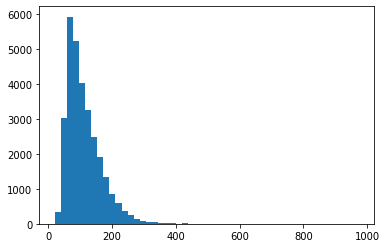

In [30]:
plt.hist(doc_lengths,bins=50)
plt.show()

## Step 3.2 (sentence-wise preprocessing):

Create Corpus

In [ ]:
# get all sentences
def make_span_data(unlabeled_corpus_with_SS_data):
    span_data = []
    for d in unlabeled_corpus_with_SS_data['documents']:
        for s in d['Law-specific_SS']:
            sd = {
                'document': d['_id'],
                'txt': d['plainText'][s[0]:s[1]],
                'start': s[0],
                'start_normalized': s[0] / len(d['plainText']),
                'end': s[1],
            }
            span_data.append(sd)
    return span_data

In [ ]:
spans = make_span_data(unlabeled_corpus_with_SS_data)

Replace line break characters (i.e. \t, \r, and \n) in unlabeled sentences with single whitespace. So that the the offset of sentence segmentation will not change 

In [ ]:
for span in spans:
    text = span['txt'].replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    span['txt'] = text

In [ ]:
spans_txt = [s['txt'] for s in spans]

Tokenizer function using Spacy

In [27]:
# basic English pipeline provided by spacy
nlp = spacy.load("en_core_web_sm")
nlp.disable_pipes('parser')
nlp.tokenizer.add_special_case('post-traumatic', [{ORTH: 'post-traumatic'}])
nlp.tokenizer.add_special_case('Dr.', [{ORTH: 'Dr.'}])
nlp.tokenizer.add_special_case('Mr.', [{ORTH: 'Mr.'}])
nlp.tokenizer.add_special_case('Jandreau v. Nicholson', [{ORTH: 'Jandreau v. Nicholson'}])
nlp.tokenizer.add_special_case('x-ray', [{ORTH: 'x-ray'}])
nlp.tokenizer.add_special_case('X-ray', [{ORTH: 'X-ray'}])
nlp.tokenizer.add_special_case('X-Ray', [{ORTH: 'X-Ray'}])
nlp.tokenizer.add_special_case('U.S.C.A.', [{ORTH: 'U.S.C.A.'}])
nlp.tokenizer.add_special_case('Vet. App.', [{ORTH: 'Vet. App.'}])
nlp.tokenizer.add_special_case('C.F.R.', [{ORTH: 'C.F.R.'}])
nlp.tokenizer.add_special_case('Fed. Cir.', [{ORTH: 'Fed. Cir.'}])

In [38]:
def spacy_tokenize(txt):
    sum_tokens = []
    for doc in nlp.pipe(txt, n_process=4):
        tokens = list(doc)
        clean_tokens = []
        for t in tokens:
            if t.pos_ == 'PUNCT':
                pass
            elif t.lemma_ == "§" or t.lemma_ == "[" or t.lemma_ == "]" or t.lemma_ == "-" :
                pass
            elif t.pos_ == 'SPACE':
                pass
            elif t.pos_ == 'NUM':
                clean_tokens.append(f'<NUM{len(t)}>')
            else:
                clean_tokens.append(t.lemma_.lower())
        
        sum_tokens.append(clean_tokens)
    return sum_tokens

In [ ]:
def spans_add_spacy_tokens(spans,tokens):
    for index, span in enumerate(spans):
        span['tokens_spacy'] = tokens[index]

## Step 3.3 (Tokenize unlabeled data): 

In [ ]:
tokens = spacy_tokenize(spans_txt)

In [ ]:
spans_add_spacy_tokens(spans,tokens)

In [32]:
import srsly
data_root = os.path.abspath(os.path.abspath(os.getcwd()))
unlabeled_corpus_with_token_path = os.path.join(data_root,'unlabeled_corpus_with_token.json')
#srsly.write_jsonl(unlabeled_corpus_with_token_path, [spans])

In [33]:
unlabeled_corpus_with_token_data = json.load(open(unlabeled_corpus_with_token_path))

In [37]:
tokens = [token['tokens_spacy'] for token in unlabeled_corpus_with_token_data]

In [39]:
token_lengths = [len(t) for t in tokens]

In [41]:
len(token_lengths)

3360495

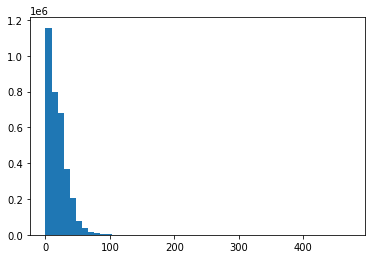

In [45]:
plt.hist(token_lengths,bins=50)
plt.show()

In [ ]:
# The sentences in the file should be in random order.
random.shuffle(tokens)

# discard sentences below a minimum length (e.g. 5 tokens).
new_tokens = [token for token in tokens if len(token) > 5]

In [ ]:
len(new_tokens)

2612948

In [ ]:
#assemble a single file, each line of which consists of a sentence's tokens, separated by a single whitespace.
def assemble_into_file(tokens,file):
    for _, token in enumerate(tokens):
        for index, i in enumerate(token):
            file.write(i)
            if index < len(token)-1: 
                file.write(" ")
            else:
                file.write(os.linesep)

In [ ]:
#create a new text file
data_root = os.path.abspath(os.path.abspath(os.getcwd()))
unlabeled_tokens_path = os.path.join(data_root, 'new_unlabeled_tokens.txt')
unlabeled_tokens_file = open(unlabeled_tokens_path,'w+')


In [ ]:
assemble_into_file(new_tokens,unlabeled_tokens_file)

In [ ]:
file = open(unlabeled_tokens_path, 'r')
lines = file.readlines()

In [ ]:
lines


# Phase 4: Developing Word Embeddings


Step 4.1 (Custom FastText embeddings): 

In [46]:
import fasttext

In [47]:
data_root = os.path.abspath(os.path.abspath(os.getcwd()))
unlabeled_tokens_path = os.path.join(data_root, 'new_unlabeled_tokens.txt')

In [9]:
data_root = os.path.abspath(os.path.abspath(os.getcwd()))
root = os.path.join(data_root, 'model.bin')

In [10]:
model_1 = fasttext.load_model(root)

In [278]:
len(model_1.words)

12557

In [51]:
model_1.get_nearest_neighbors('veteran',20)

[(0.6970693469047546, 'his'),
 (0.6890307068824768, "'s"),
 (0.6639660000801086, 'the'),
 (0.6527822613716125, 'appellant'),
 (0.6402354836463928, 'he'),
 (0.5961762070655823, 'furthermore'),
 (0.5908841490745544, 'additionally'),
 (0.583612322807312, 'have'),
 (0.57666015625, 'that'),
 (0.576265811920166, 'lastly'),
 (0.5614780187606812, 'moreover'),
 (0.540142834186554, 'c.s.'),
 (0.5362436175346375, 'february'),
 (0.5333990454673767, 'september'),
 (0.5316503047943115, 'january'),
 (0.5311999917030334, 'reflect'),
 (0.5270800590515137, 'here'),
 (0.5254421234130859, 'likewise'),
 (0.5235478281974792, 'march'),
 (0.5195447206497192, 'j.b.b.')]

In [53]:
model_1.get_nearest_neighbors('appellant',20)

[(0.6527822017669678, 'veteran'),
 (0.5958418846130371, 'kendall'),
 (0.5609190464019775, 'darla'),
 (0.5507221817970276, 'mahlin'),
 (0.5506866574287415, 'penelope'),
 (0.5485872030258179, 'represent'),
 (0.5479632616043091, 'sean'),
 (0.5469957590103149, 'jarvi'),
 (0.5424832701683044, 'jeany'),
 (0.5416982769966125, 'viterna'),
 (0.5343852639198303, 'lavan'),
 (0.5317940711975098, 'gronbeck'),
 (0.52616947889328, 'huffman'),
 (0.5211508870124817, 'ravin'),
 (0.5166838765144348, 'the'),
 (0.5164158344268799, 'girard'),
 (0.5148105621337891, 'accredited'),
 (0.5123250484466553, 'by'),
 (0.5112201571464539, 'attorney'),
 (0.5108230710029602, 'esquire')]

In [54]:
model_1.get_nearest_neighbors('vet',20)

[(0.8019217848777771, 'app'),
 (0.7466469407081604, 'v.'),
 (0.723072350025177, 'vet.'),
 (0.715280294418335, 'app.'),
 (0.7076164484024048, 'see'),
 (0.7039514780044556, '.app'),
 (0.6976066827774048, 'app.112'),
 (0.6291811466217041, 'derwinksi'),
 (0.6056645512580872, 'jolley'),
 (0.6009442210197449, 'diorio'),
 (0.593504786491394, '<NUM3>'),
 (0.5913609266281128, 'bagwell'),
 (0.5901135802268982, 'prinicpi'),
 (0.5840316414833069, 'brown'),
 (0.5804855823516846, 'manio'),
 (0.5780920386314392, '.'),
 (0.5753897428512573, 'nicolson'),
 (0.5732588171958923, 'derwinski'),
 (0.5732576847076416, 'wensch'),
 (0.5729243755340576, "aff'd")]

In [73]:
model_1.get_nearest_neighbors('service',20)

[(0.6706150770187378, 'connection'),
 (0.5866191983222961, 'disability'),
 (0.5822980403900146, 'disease'),
 (0.5665377378463745, 'active'),
 (0.5499465465545654, 'incur'),
 (0.5487679243087769, 'military'),
 (0.5475127100944519, 'injury'),
 (0.5400721430778503, 'disorder'),
 (0.5393965840339661, 'inservice'),
 (0.523131787776947, 'establish'),
 (0.5220890045166016, 'condition'),
 (0.5214115977287292, 'connect'),
 (0.5116925239562988, 'current'),
 (0.5114433169364929, 'during'),
 (0.5024224519729614, 'grant'),
 (0.4998444616794586, 'aggravate'),
 (0.49137449264526367, 'service-'),
 (0.4851112365722656, 'entitlement'),
 (0.48012346029281616, 'in-'),
 (0.47408008575439453, 'post')]

In [57]:
model_1.get_nearest_neighbors('cause',20)

[(0.6528679132461548, 'contributor'),
 (0.6505553722381592, 'contributing'),
 (0.6356167793273926, 'attributable'),
 (0.6322312951087952, 'contributory'),
 (0.6179666519165039, 'contribute'),
 (0.612808883190155, 'exacerbate'),
 (0.6025742292404175, 'aggravated'),
 (0.6007651090621948, 'secondarily'),
 (0.5991052985191345, 'accelerate'),
 (0.5944975018501282, 'precipitate'),
 (0.5903897285461426, 'causative'),
 (0.583692193031311, 'causally'),
 (0.5830510854721069, 'permanently'),
 (0.577908992767334, 'due'),
 (0.5760119557380676, 'likely'),
 (0.5731321573257446, 'result'),
 (0.568789005279541, 'definitely'),
 (0.5676520466804504, 'culprit'),
 (0.5671285390853882, 'proximately'),
 (0.5578218102455139, 'progression')]

In [72]:
model_1.get_nearest_neighbors('remanded',20)

[(0.6920429468154907, 'handed'),
 (0.6003784537315369, 'via'),
 (0.5852563977241516, 'management'),
 (0.5428857207298279, 'accordingly'),
 (0.5402928590774536, 'remands'),
 (0.5376554727554321, 'hereby'),
 (0.5052216649055481, 'amc'),
 (0.4835907816886902, 'action'),
 (0.4780319333076477, 'blinded'),
 (0.4778415560722351, 'center'),
 (0.45017504692077637, 'unadjudicated'),
 (0.44785240292549133, 'appealable'),
 (0.44583117961883545, 'd.c.'),
 (0.44096365571022034, 'dc'),
 (0.43990564346313477, 'hereafter'),
 (0.43690967559814453, 'remandable'),
 (0.433500200510025, 'regrettably'),
 (0.4321027994155884, 'ro&ic'),
 (0.4250560402870178, 'prickett'),
 (0.4243011772632599, 'abovementioned')]

In [58]:
model_1.get_nearest_neighbors('caused',20)

[(0.6882616877555847, 'cause'),
 (0.6101967692375183, 'contributor'),
 (0.6060751080513, 'definitely'),
 (0.6045461297035217, 'confused'),
 (0.5834552645683289, 'probably'),
 (0.5822371244430542, 'acutely'),
 (0.5793704390525818, 'unlikely'),
 (0.5784780979156494, 'real'),
 (0.5691012740135193, 'stressed'),
 (0.5626106858253479, 'quite'),
 (0.5601495504379272, 'distressed'),
 (0.5570107102394104, 'feel'),
 (0.5551754236221313, 'seem'),
 (0.554784893989563, 'prone'),
 (0.5535833835601807, 'causative'),
 (0.5523353815078735, 'distension'),
 (0.5502200126647949, 'spontaneous'),
 (0.548194944858551, 'contributing'),
 (0.5473364591598511, 'mechanism'),
 (0.5470985770225525, 'extremely')]

In [59]:
model_1.get_nearest_neighbors('remanded',20)

[(0.6920429468154907, 'handed'),
 (0.6003784537315369, 'via'),
 (0.5852563977241516, 'management'),
 (0.5428857207298279, 'accordingly'),
 (0.5402928590774536, 'remands'),
 (0.5376554727554321, 'hereby'),
 (0.5052216649055481, 'amc'),
 (0.4835907816886902, 'action'),
 (0.4780319333076477, 'blinded'),
 (0.4778415560722351, 'center'),
 (0.45017504692077637, 'unadjudicated'),
 (0.44785240292549133, 'appealable'),
 (0.44583117961883545, 'd.c.'),
 (0.44096365571022034, 'dc'),
 (0.43990564346313477, 'hereafter'),
 (0.43690967559814453, 'remandable'),
 (0.433500200510025, 'regrettably'),
 (0.4321027994155884, 'ro&ic'),
 (0.4250560402870178, 'prickett'),
 (0.4243011772632599, 'abovementioned')]

In [60]:
model_1.get_nearest_neighbors('vietnam',20)

[(0.9138283133506775, 'republic'),
 (0.8844241499900818, 'rvn'),
 (0.80441814661026, 'era'),
 (0.7652279734611511, 'country'),
 (0.7401430606842041, 'korea'),
 (0.7182396650314331, 'thailand'),
 (0.7168539762496948, 'korean'),
 (0.7163017392158508, 'danang'),
 (0.716281533241272, 'nam'),
 (0.7136986255645752, 'nang'),
 (0.7015897035598755, 'shore'),
 (0.6942739486694336, 'territorial'),
 (0.6791969537734985, 'offshore'),
 (0.6730896830558777, 'guam'),
 (0.670276939868927, 'da'),
 (0.6683924198150635, 'demilitarized'),
 (0.6683389544487, 'tour'),
 (0.666976809501648, 'mainland'),
 (0.6644023060798645, 'vsm'),
 (0.664049506187439, 'pleiku')]

In [61]:
model_1.get_nearest_neighbors('see',20)

[(0.7388982772827148, 'v.'),
 (0.7076159119606018, 'vet'),
 (0.6899507641792297, '<NUM4>'),
 (0.6708472967147827, 'id.'),
 (0.6665692329406738, 'cf'),
 (0.6632587313652039, '<NUM3>'),
 (0.6573101282119751, 'app.'),
 (0.6549177169799805, 'vet.'),
 (0.6384789347648621, '<NUM2>'),
 (0.6375328302383423, 'derwinksi'),
 (0.6334337592124939, 'diorio'),
 (0.630824625492096, 'supra'),
 (0.6181110143661499, 'prinicpi'),
 (0.6112388968467712, 'f.'),
 (0.6091493368148804, 'app'),
 (0.6084616184234619, 'manio'),
 (0.6077641844749451, '&'),
 (0.6039893627166748, '<NUM7>'),
 (0.6007150411605835, 'brown'),
 (0.5988039374351501, '101(16')]

In [62]:
model_1.get_nearest_neighbors('korea',20)

[(0.8053224682807922, 'korean'),
 (0.7894306778907776, 'dmz'),
 (0.786448061466217, 'germany'),
 (0.7789478302001953, 'demilitarized'),
 (0.7456217408180237, 'station'),
 (0.7401430010795593, 'vietnam'),
 (0.7398949861526489, 'panama'),
 (0.728923499584198, 'okinawa'),
 (0.7229666113853455, 'infantry'),
 (0.7161368727684021, 'casey'),
 (0.7045037746429443, 'tour'),
 (0.6984030604362488, 'overseas'),
 (0.6965556740760803, 'thailand'),
 (0.6955015659332275, 'rvn'),
 (0.6785236597061157, '38th'),
 (0.676867663860321, 'engineers'),
 (0.6739294528961182, 'firefighting'),
 (0.6720244884490967, 'guam'),
 (0.6716691255569458, 'seoul'),
 (0.6705062985420227, 'country')]

In [63]:
model_1.get_nearest_neighbors('disease',20)

[(0.6489488482475281, 'incur'),
 (0.618872344493866, 'diseased'),
 (0.6185226440429688, 'injury'),
 (0.5822979807853699, 'service'),
 (0.5441792011260986, 'disability'),
 (0.5377976298332214, 'aggravate'),
 (0.533419132232666, 'establish'),
 (0.5153861045837402, 'diseases'),
 (0.4957745373249054, 'condition'),
 (0.47748371958732605, 'established'),
 (0.4758523404598236, 'aggravation'),
 (0.4643342196941376, 'diagnose'),
 (0.46368667483329773, 'manifestation'),
 (0.4595898389816284, 'grant'),
 (0.4523635506629944, 'leukemias'),
 (0.44995802640914917, 'angioendotheliomatosis'),
 (0.449052095413208, 'arthritis'),
 (0.44705063104629517, 'clearcut'),
 (0.44596314430236816, 'manifest'),
 (0.4413725733757019, 'artherosclerosis')]

In [64]:
model_1.get_nearest_neighbors('injury',20)

[(0.6331168413162231, 'reinjury'),
 (0.6231255531311035, 'sustain'),
 (0.6185226440429688, 'disease'),
 (0.5897164940834045, 'disability'),
 (0.5824495553970337, 'injury(ie'),
 (0.5773167610168457, 'aggravate'),
 (0.5672973394393921, 'suffer'),
 (0.5578083992004395, 'incur'),
 (0.5475127100944519, 'service'),
 (0.5439328551292419, 'inservice'),
 (0.5436097979545593, 'aggravation'),
 (0.5383185744285583, 'crush'),
 (0.5255894660949707, "service'-the"),
 (0.5175805687904358, 'mva'),
 (0.5172773599624634, 'in-'),
 (0.5106347799301147, 'service"-'),
 (0.5083968639373779, 'service"--the'),
 (0.5056675672531128, 'avulsion'),
 (0.497504323720932, 'inccurrence'),
 (0.49427351355552673, 'service"-the')]

In [65]:
model_1.get_nearest_neighbors('medical',20)

[(0.5951398611068726, 'opinion'),
 (0.5646108388900757, 'lay'),
 (0.5636569261550903, 'record'),
 (0.5610337257385254, 'competent'),
 (0.5592198371887207, 'professional'),
 (0.5386662483215332, 'treatise'),
 (0.5365573763847351, 'evidence'),
 (0.530758798122406, 'inccurrence'),
 (0.5219876766204834, 'etiological'),
 (0.5157467126846313, 'lie'),
 (0.512498676776886, 'expertise'),
 (0.5077372193336487, 'nexus'),
 (0.496512770652771, 'probative'),
 (0.4891665279865265, 'nieves-'),
 (0.4859798550605774, 'diagnosis'),
 (0.48467543721199036, 'physician'),
 (0.48231443762779236, 'nonprobative'),
 (0.4755994975566864, 'private'),
 (0.474305659532547, 'proffer'),
 (0.4741598665714264, 'r.evid')]

In [66]:
model_1.get_nearest_neighbors('disability',20)

[(0.7392866015434265, 'disability-'),
 (0.648181140422821, 'current'),
 (0.6086663007736206, 'connection'),
 (0.6058632135391235, 'service-'),
 (0.5988626480102539, 'connected'),
 (0.5897166132926941, 'injury'),
 (0.5866191983222961, 'service'),
 (0.5812058448791504, 'connect'),
 (0.5790224671363831, 'disorder'),
 (0.553720235824585, 'aggravation'),
 (0.544179379940033, 'disease'),
 (0.5416293740272522, 'nonservice-'),
 (0.5348824262619019, 'disorder(s'),
 (0.5307477712631226, 'established'),
 (0.5251157283782959, 'compensation'),
 (0.5185249447822571, 'establish'),
 (0.5170044898986816, 'disability(ie'),
 (0.51509690284729, 'disablement'),
 (0.499919593334198, 'nonservice'),
 (0.4744463562965393, 'currently-')]

In [67]:
model_1.get_nearest_neighbors('record',20)

[(0.7308458685874939, 'treatment'),
 (0.7118605971336365, 'str'),
 (0.6877104640007019, 'smr'),
 (0.6671508550643921, 'private'),
 (0.6085523366928101, 'document'),
 (0.6048831343650818, 'personnel'),
 (0.5948179960250854, 'available'),
 (0.5926284193992615, 'folder'),
 (0.5861116051673889, 'spr'),
 (0.5813270211219788, 'relevant'),
 (0.5812823176383972, 'outstanding'),
 (0.5787395238876343, 'loma'),
 (0.577276349067688, 'compile'),
 (0.5742077231407166, 'pmr'),
 (0.5724474191665649, 'obtain'),
 (0.5645878911018372, 'contain'),
 (0.5636568665504456, 'medical'),
 (0.5628746151924133, 'linda'),
 (0.5529988408088684, 'voluminous'),
 (0.5526275634765625, 'outpatient')]

In [68]:
model_1.get_nearest_neighbors('diabetic',20)

[(0.8279265761375427, 'retinopathy'),
 (0.8170487284660339, 'nephropathy'),
 (0.7681580185890198, 'diabetes'),
 (0.7515228390693665, 'insulin'),
 (0.7488563656806946, 'dm'),
 (0.7342378497123718, 'mellitus'),
 (0.7179155349731445, 'diabete'),
 (0.691027045249939, 'microvascular'),
 (0.6873170137405396, 'hyperglycemia'),
 (0.6858533024787903, 'microalbuminuria'),
 (0.6851164698600769, 'peripheral'),
 (0.6800626516342163, 'neuropathy'),
 (0.6761056184768677, 'nephrotic'),
 (0.668426513671875, 'neovascular'),
 (0.668342649936676, 'nonproliferative'),
 (0.6603558659553528, 'glaucoma'),
 (0.656173050403595, 'neovascularization'),
 (0.6544003486633301, 'pvd'),
 (0.6505539417266846, 'glaucomatous'),
 (0.6499841213226318, 'fasting')]

# Phase 5: Training Classifiers

## Step 5.1 (TFIDF featurization):

In [11]:
# get all sentences assuming every annotation is a sentence
def make_span_data(documents_by_id, types_by_id, annotations):
    span_data = []
    for a in annotations:
        start = a['start']
        end = a['end']
        document_txt = documents_by_id[a['document']]['plainText']
        atype = a['type']
        sd = {'txt': document_txt[start:end],
              'document': a['document'],
              'type': types_by_id[atype]['name'],
              'start': a['start'],
              'start_normalized': a['start'] / len(document_txt),
              'end': a['end']}
        span_data.append(sd)
    return span_data

In [12]:
train_spans = make_span_data(documents_by_id, types_by_id, annotations)
dev_spans = make_span_data(dev_documents_by_id, dev_types_by_id, dev_annotations)
test_spans = make_span_data(test_documents_by_id, test_types_by_id, test_annotations)

In [13]:
train_spans_labels = [s['type'] for s in train_spans]
dev_spans_labels = [s['type'] for s in dev_spans]
test_spans_labels = [s['type'] for s in test_spans]

In [14]:
train_spans_txt = [s['txt'] for s in train_spans]
dev_spans_txt = [s['txt'] for s in dev_spans]
test_spans_txt = [s['txt'] for s in test_spans]

In [15]:
print(f'train: {len(train_spans)}; dev: {len(dev_spans)}; test: {len(test_spans)}')

train: 7528; dev: 849; test: 863


In [16]:
def spacy_tokenize(txt):
    doc = nlp(txt)
    tokens = list(doc)
    clean_tokens = []
    for t in tokens:
        if t.pos_ == 'PUNCT':
            pass
        elif t.lemma_ == "§" or t.lemma_ == "[" or t.lemma_ == "]" or t.lemma_ == "-" :
            pass
        elif t.pos_ == 'SPACE':
            pass
        elif t.pos_ == 'NUM':
            clean_tokens.append(f'<NUM{len(t)}>')
        else:
            clean_tokens.append(t.lemma_.lower())
    
    return clean_tokens

def tokenize_spans(spans):
    for s in spans:
        s['tokens_spacy'] = spacy_tokenize(s['txt'])

In [19]:
nlp = spacy.load("en_core_web_sm")
# basic English pipeline provided by spacy
nlp.disable_pipes('parser')
nlp.tokenizer.add_special_case('post-traumatic', [{ORTH: 'post-traumatic'}])
nlp.tokenizer.add_special_case('Dr.', [{ORTH: 'Dr.'}])
nlp.tokenizer.add_special_case('Mr.', [{ORTH: 'Mr.'}])
nlp.tokenizer.add_special_case('Jandreau v. Nicholson', [{ORTH: 'Jandreau v. Nicholson'}])
nlp.tokenizer.add_special_case('x-ray', [{ORTH: 'x-ray'}])
nlp.tokenizer.add_special_case('X-ray', [{ORTH: 'X-ray'}])
nlp.tokenizer.add_special_case('X-Ray', [{ORTH: 'X-Ray'}])
nlp.tokenizer.add_special_case('U.S.C.A.', [{ORTH: 'U.S.C.A.'}])
nlp.tokenizer.add_special_case('Vet. App.', [{ORTH: 'Vet. App.'}])
nlp.tokenizer.add_special_case('C.F.R.', [{ORTH: 'C.F.R.'}])
nlp.tokenizer.add_special_case('Fed. Cir.', [{ORTH: 'Fed. Cir.'}])
tokenize_spans(train_spans)
tokenize_spans(dev_spans)
tokenize_spans(test_spans)

In [20]:
spacy_tfidf_vectorizer = TfidfVectorizer(tokenizer=spacy_tokenize,
                                         min_df=3,
                                         ngram_range=(1,1))
spacy_tfidf_vectorizer = spacy_tfidf_vectorizer.fit(train_spans_txt)
tfidf_features_spacy = spacy_tfidf_vectorizer.get_feature_names()

In [21]:
# numpy feature vector extension
train_tfidf_spacy = spacy_tfidf_vectorizer.transform(train_spans_txt).toarray()
print(train_tfidf_spacy.shape)
train_starts_normalized = np.array([s['start_normalized'] for s in train_spans])
print(train_starts_normalized.shape)
print(np.expand_dims(train_starts_normalized, axis=1).shape)
ext = np.concatenate((train_tfidf_spacy, 
                      np.expand_dims(train_starts_normalized, axis=1)), axis=1)
print(ext.shape)

(7528, 2406)
(7528,)
(7528, 1)
(7528, 2407)


## Step 5.2 (Word Embedding Featurization):

In [22]:
def make_tfidf_feature_vectors_and_labels(spans, vectorizer):
    # function takes long to execute
    # note: we un-sparse the matrix here to be able to manipulate it
    tfidf = spacy_tfidf_vectorizer.transform([s['txt'] for s in spans]).toarray()
    
    starts_normalized = np.array([s['start_normalized'] for s in spans])
    
    
    y = np.array([s['type'] for s in spans])
    X = np.concatenate((tfidf, np.expand_dims(starts_normalized, axis=1)),  axis=1)
    return X, y

In [36]:

def make_embedding_feature_vectors_and_labels(spans,fasttext_model):
        
        tokens = [s['tokens_spacy'] for s in spans]
        embedding = np.empty((len(spans),100), dtype='float32')
        for index_i, i in enumerate(tokens):
            for index_j, j in enumerate(i):
                if index_j == 0:
                    vector = fasttext_model.get_word_vector(j)
                else:
                    vector = vector + fasttext_model.get_word_vector(j)
            if len(i) >= 1:
                vector = vector/len(i)
            vector = np.expand_dims(vector, axis=0)
            embedding[index_i] = vector


        starts_normalized = np.array([s['start_normalized'] for s in spans])

        #normalized num_tokens
        num_tokens = np.array([len(s['tokens_spacy']) for s in spans])
        num_tokens = (num_tokens - np.mean(num_tokens))/(np.std(num_tokens)+1e-9)

        
        X = np.concatenate((embedding, np.expand_dims(starts_normalized, axis=1), np.expand_dims(num_tokens, axis=1)), axis=1)
        return X

In [24]:
tfidf_train_X, tfidf_train_y = make_tfidf_feature_vectors_and_labels(train_spans, spacy_tfidf_vectorizer)
tfidf_dev_X, tfidf_dev_y = make_tfidf_feature_vectors_and_labels(dev_spans, spacy_tfidf_vectorizer)
tfidf_test_X, tfidf_test_y = make_tfidf_feature_vectors_and_labels(test_spans, spacy_tfidf_vectorizer)

In [25]:
embedding_train_X, embedding_train_y = make_embedding_feature_vectors_and_labels(train_spans, spacy_tfidf_vectorizer)
embedding_dev_X, embedding_dev_y = make_embedding_feature_vectors_and_labels(dev_spans, spacy_tfidf_vectorizer)
embedding_test_X, embedding_test_y = make_embedding_feature_vectors_and_labels(test_spans, spacy_tfidf_vectorizer)

In [26]:
print(f'{tfidf_train_X.shape} {tfidf_train_y.shape}')
print(f'{tfidf_dev_X.shape} {tfidf_dev_y.shape}')
print(f'{tfidf_test_X.shape} {tfidf_test_y.shape}')

(7528, 2407) (7528,)
(849, 2407) (849,)
(863, 2407) (863,)


In [27]:
print(f'{embedding_train_X.shape} {embedding_train_y.shape}')
print(f'{embedding_dev_X.shape} {embedding_dev_y.shape}')
print(f'{embedding_test_X.shape} {embedding_test_y.shape}')

(7528, 102) (7528,)
(849, 102) (849,)
(863, 102) (863,)


## Step 5.3 (Model Training): 

## Linear model -- Logistic Regression
### using TFIDF featurization

In [105]:
from sklearn.linear_model import LogisticRegression 

In [180]:
clf_LR_tfidf = LogisticRegression(class_weight='balanced', multi_class='multinomial', max_iter=200, n_jobs=-1)
clf_LR_tfidf = clf_LR_tfidf.fit(tfidf_train_X, tfidf_train_y)

In [181]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf_LR_tfidf.predict(tfidf_train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf_LR_tfidf.predict(tfidf_dev_X)))

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.94      0.99      0.97        84
                        CaseHeader       0.99      0.98      0.98        82
                         CaseIssue       0.77      1.00      0.87        77
                          Citation       0.97      0.97      0.97       993
                   ConclusionOfLaw       0.67      0.95      0.78       168
                          Evidence       0.92      0.81      0.86      2099
EvidenceBased/Intermediate Finding       0.70      0.65      0.68       648
            EvidenceBasedReasoning       0.54      0.67      0.60       553
                            Header       0.98      0.97      0.98       716
                       LegalPolicy       0.48      0.97      0.64        80
                         LegalRule       0.88      0.79      0.84       851
              PolicyBasedReasoning       0.38      1.00      0.56        20
    

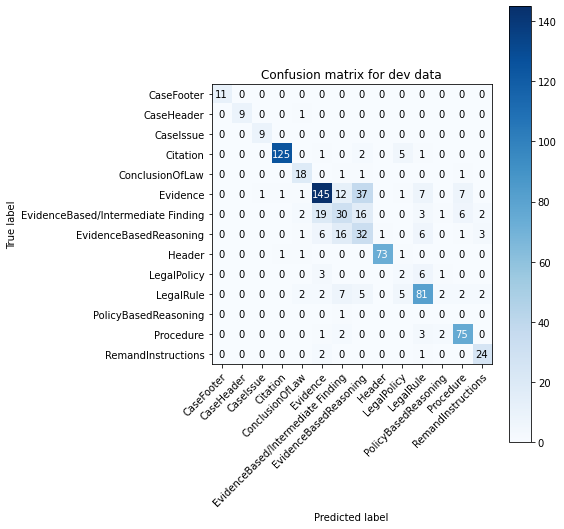

In [182]:
plot_confusion_matrix(dev_spans_labels, clf_LR_tfidf.predict(tfidf_dev_X), classes=list(clf_LR_tfidf.classes_),
                      title='Confusion matrix for dev data')
plt.show()

In [197]:
def prediction_errors(clf, eval_spans, vectorizer, 
                      select_true_label=None, 
                      select_pred_label=None):
    eval_X, eval_y = make_tfidf_feature_vectors_and_labels(eval_spans, vectorizer)
    eval_spans_txt = [s['txt'] for s in eval_spans]
    eval_spans_labels = [s['type'] for s in eval_spans]
    pred_y = clf.predict(eval_X)
    for i in range(len(eval_spans)):
        true_label = eval_spans_labels[i]
        pred_label = pred_y[i]
        if true_label != pred_label:
            if select_true_label and true_label != select_true_label: continue
            if select_pred_label and pred_label != select_pred_label: continue
            doc_name = dev_documents_by_id[eval_spans[i]['document']]['name']
            print('sentence # '+str(i)+' / case '+doc_name+' / @'+str(eval_spans[i]['start']))
            print('pred: '+pred_label+' / true: '+true_label)
            print(eval_spans[i]['txt'])
            print()

In [199]:
prediction_errors(clf_LR_tfidf,
                  random.sample(dev_spans, 100),
                  spacy_tfidf_vectorizer,
                  select_pred_label='EvidenceBasedReasoning')

sentence # 25 / case 1203065.txt / @24958
pred: EvidenceBasedReasoning / true: EvidenceBased/Intermediate Finding
The Board recognizes that the Veteran can attest to factual matters of which he had first-hand knowledge. 

sentence # 31 / case 1205178.txt / @7906
pred: EvidenceBasedReasoning / true: Evidence
The Veteran has not made the RO or the Board aware of any additional evidence that needs to be obtained in order to fairly decide his claim

sentence # 33 / case 0601461.txt / @10321
pred: EvidenceBasedReasoning / true: EvidenceBased/Intermediate Finding
According to the Veterans 
Benefits Administration, despite the lack of any scientific 
evidence to document transmission of HCV with air gun 
injectors, it is biologically plausible.  

sentence # 46 / case 1418226.txt / @4454
pred: EvidenceBasedReasoning / true: Evidence
This report includes a review of studies addressing exposure to TCE, and Tetrachloroethylene or PCE, as well as a mixture of the two, and a discussion of disease 

## Linear model -- Logistic Regression
### using embedding featurization

In [225]:
clf_LR_embedding = LogisticRegression(class_weight='balanced', multi_class='multinomial', max_iter=200, n_jobs=-1)
clf_LR_embedding = clf_LR_embedding.fit(embedding_train_X, embedding_train_y)

In [226]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf_LR_embedding.predict(embedding_train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf_LR_embedding.predict(embedding_dev_X)))

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.94      0.99      0.97        84
                        CaseHeader       0.99      0.98      0.98        82
                         CaseIssue       0.74      0.99      0.84        77
                          Citation       0.98      0.95      0.96       993
                   ConclusionOfLaw       0.61      0.87      0.72       168
                          Evidence       0.90      0.74      0.81      2099
EvidenceBased/Intermediate Finding       0.54      0.45      0.49       648
            EvidenceBasedReasoning       0.36      0.45      0.40       553
                            Header       0.98      0.97      0.98       716
                       LegalPolicy       0.27      0.78      0.40        80
                         LegalRule       0.82      0.66      0.73       851
              PolicyBasedReasoning       0.11      1.00      0.19        20
    

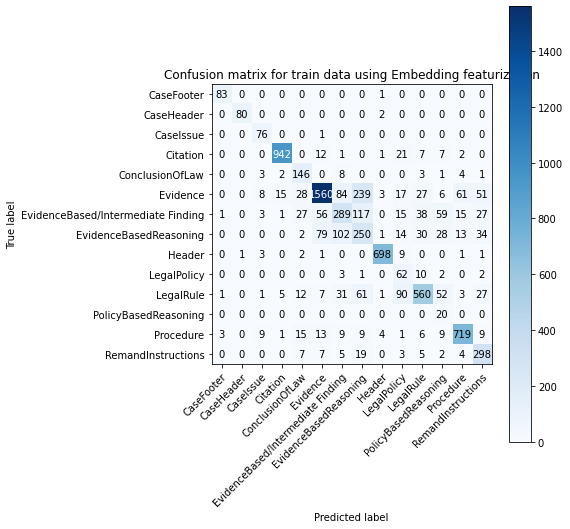

In [166]:
plot_confusion_matrix(train_spans_labels, clf_LR_embedding.predict(embedding_train_X), classes=list(clf_LR_embedding.classes_),
                      title='Confusion matrix for train data using Embedding featurization')
plt.show()

In [442]:
prediction_errors(clf,
                  random.sample(train_spans, 100),
                  spacy_tfidf_vectorizer,
                  select_pred_label='Evidence')

sentence # 7 / case 0617470.txt / @2753
pred: Evidence / true: LegalRule
The veteran's service medical records, VA medical treatment 
records, and identified private medical records have been 
obtained to the extent available. 

sentence # 39 / case 1428531.txt / @24115
pred: Evidence / true: EvidenceBasedReasoning
The Veteran reported that his primary complaint was "too much free time" since retiring.  

sentence # 43 / case 1118746.txt / @6319
pred: Evidence / true: EvidenceBasedReasoning
The Veteran's private treatment records include records from a private physician, A.F., M.D., indicating that insomnia is among the Veteran's active and ongoing problems. 

sentence # 84 / case 1428531.txt / @24648
pred: Evidence / true: EvidenceBasedReasoning
The Veteran indicated that he was treated with Prozac after his father died in 1998 and he reported thoughts of suicide after his friend died. 

sentence # 91 / case 0916473.txt / @11404
pred: Evidence / true: EvidenceBasedReasoning
The servic

## nonlinear model -- RandomForests

### using embedding featurization

## Random Search

In [33]:
n_estimators = [int(x) for x in np.linspace(start = 80, stop = 140, num = 30)]

#max_features = ['auto', 'sqrt', 'None']

max_depth = [int(x) for x in np.linspace(8, 18, num = 10)]


bootstrap = [True, False]


random_grid = {'n_estimators': n_estimators,
               #'max_features': max_features,
               'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
              }
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [8, 9, 10, 11, 12, 13, 14, 15, 16, 18],
 'n_estimators': [80,
                  82,
                  84,
                  86,
                  88,
                  90,
                  92,
                  94,
                  96,
                  98,
                  100,
                  102,
                  104,
                  106,
                  108,
                  111,
                  113,
                  115,
                  117,
                  119,
                  121,
                  123,
                  125,
                  127,
                  129,
                  131,
                  133,
                  135,
                  137,
                  140]}


In [151]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 10, verbose=2, random_state=42, n_jobs = -1, scoring='f1_macro')
# Fit the random search model
rf_random.fit(embedding_train_X, embedding_train_y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [8, 8, 9, 10, 11, 11, 12,
                                                      13, 14, 15],
                                        'n_estimators': [80, 86, 92, 98, 105,
                                                         111, 117, 124, 130,
                                                         136, 143, 149, 155,
                                                         162, 168, 174, 181,
                                                         187, 193, 200]},
                   random_state=42, scoring='f1_macro', verbose=2)

In [215]:
rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator = rf, param_grid = random_grid, verbose=2, n_jobs = -1, scoring='f1_macro')
# Fit the random search model
rf_grid.fit(embedding_train_X, embedding_train_y)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
[CV] END .....................max_depth=11, n_estimators=174; total time=  11.9s
[CV] END ......................max_depth=8, n_estimators=174; total time=   8.7s
[CV] END ......................max_depth=8, n_estimators=174; total time=   9.7s
[CV] END ......................max_depth=8, n_estimators=143; total time=   8.8s
[CV] END .....................max_depth=13, n_estimators=193; total time=  14.6s
[CV] END .....................max_depth=12, n_estimators=130; total time=  10.0s
[CV] END .....................max_depth=11, n_estimators=174; total time=  11.0s
[CV] END .....................max_depth=10, n_estimators=136; total time=  10.4s
[CV] END .....................max_depth=10, n_estimators=136; total time=   9.4s
[CV] END .....................max_depth=14, n_estimators=143; total time=  11.2s
[CV] END .....................max_depth=14, n_estimators=168; total time=  12.8s
[CV] END ......................max_depth=9, n

[CV] END .....................max_depth=11, n_estimators=174; total time=  11.9s
[CV] END ......................max_depth=8, n_estimators=174; total time=   8.7s
[CV] END ......................max_depth=8, n_estimators=174; total time=   9.8s
[CV] END ......................max_depth=8, n_estimators=143; total time=   8.7s
[CV] END .....................max_depth=13, n_estimators=193; total time=  14.6s
[CV] END .....................max_depth=12, n_estimators=130; total time=  10.0s
[CV] END .....................max_depth=11, n_estimators=174; total time=  11.1s
[CV] END .....................max_depth=10, n_estimators=136; total time=  10.4s
[CV] END .....................max_depth=10, n_estimators=136; total time=   9.3s
[CV] END .....................max_depth=14, n_estimators=143; total time=  11.1s
[CV] END .....................max_depth=14, n_estimators=168; total time=  12.8s
[CV] END ......................max_depth=9, n_estimators=111; total time=   7.3s
[CV] END ...................

[CV] END .....................max_depth=11, n_estimators=174; total time=  11.9s
[CV] END ......................max_depth=8, n_estimators=174; total time=   8.7s
[CV] END ......................max_depth=8, n_estimators=174; total time=   9.9s
[CV] END ......................max_depth=8, n_estimators=143; total time=   8.8s
[CV] END .....................max_depth=13, n_estimators=193; total time=  14.7s
[CV] END .....................max_depth=12, n_estimators=130; total time=   9.9s
[CV] END .....................max_depth=11, n_estimators=174; total time=  11.0s
[CV] END .....................max_depth=11, n_estimators=174; total time=  13.5s
[CV] END .....................max_depth=10, n_estimators=136; total time=   9.5s
[CV] END .....................max_depth=14, n_estimators=143; total time=  11.1s
[CV] END .....................max_depth=14, n_estimators=168; total time=  12.9s
[CV] END ......................max_depth=9, n_estimators=111; total time=   7.1s
[CV] END ...................

[CV] END .....................max_depth=11, n_estimators=174; total time=  11.8s
[CV] END .....................max_depth=11, n_estimators=174; total time=  11.0s
[CV] END ......................max_depth=8, n_estimators=143; total time=   8.3s
[CV] END .....................max_depth=13, n_estimators=193; total time=  14.7s
[CV] END .....................max_depth=13, n_estimators=193; total time=  15.9s
[CV] END .....................max_depth=12, n_estimators=130; total time=   9.0s
[CV] END .....................max_depth=11, n_estimators=174; total time=  13.2s
[CV] END .....................max_depth=10, n_estimators=136; total time=   9.4s
[CV] END .....................max_depth=14, n_estimators=143; total time=  11.1s
[CV] END .....................max_depth=14, n_estimators=143; total time=  10.9s
[CV] END .....................max_depth=14, n_estimators=168; total time=  13.8s
[CV] END ......................max_depth=9, n_estimators=111; total time=   7.7s
[CV] END ...................

[CV] END .....................max_depth=11, n_estimators=174; total time=  11.9s
[CV] END ......................max_depth=8, n_estimators=174; total time=   8.7s
[CV] END ......................max_depth=8, n_estimators=174; total time=   9.8s
[CV] END ......................max_depth=8, n_estimators=143; total time=   8.8s
[CV] END .....................max_depth=13, n_estimators=193; total time=  14.7s
[CV] END .....................max_depth=12, n_estimators=130; total time=   9.9s
[CV] END .....................max_depth=11, n_estimators=174; total time=  11.0s
[CV] END .....................max_depth=11, n_estimators=174; total time=  13.4s
[CV] END .....................max_depth=10, n_estimators=136; total time=   9.5s
[CV] END .....................max_depth=14, n_estimators=143; total time=  11.1s
[CV] END .....................max_depth=14, n_estimators=168; total time=  12.9s
[CV] END ......................max_depth=9, n_estimators=111; total time=   7.0s
[CV] END ...................

[CV] END .....................max_depth=11, n_estimators=174; total time=  11.9s
[CV] END ......................max_depth=8, n_estimators=174; total time=   8.7s
[CV] END ......................max_depth=8, n_estimators=143; total time=   8.1s
[CV] END ......................max_depth=8, n_estimators=143; total time=   8.7s
[CV] END .....................max_depth=13, n_estimators=193; total time=  14.2s
[CV] END .....................max_depth=12, n_estimators=130; total time=  10.3s
[CV] END .....................max_depth=12, n_estimators=130; total time=   8.9s
[CV] END .....................max_depth=11, n_estimators=174; total time=  13.2s
[CV] END .....................max_depth=10, n_estimators=136; total time=   9.4s
[CV] END .....................max_depth=14, n_estimators=143; total time=  11.2s
[CV] END .....................max_depth=14, n_estimators=168; total time=  12.8s
[CV] END .....................max_depth=14, n_estimators=168; total time=  14.0s
[CV] END ...................

[CV] END .....................max_depth=11, n_estimators=174; total time=  11.9s
[CV] END ......................max_depth=8, n_estimators=174; total time=   8.8s
[CV] END ......................max_depth=8, n_estimators=143; total time=   8.2s
[CV] END ......................max_depth=8, n_estimators=143; total time=   8.8s
[CV] END .....................max_depth=13, n_estimators=193; total time=  14.2s
[CV] END .....................max_depth=12, n_estimators=130; total time=  10.3s
[CV] END .....................max_depth=12, n_estimators=130; total time=   8.9s
[CV] END .....................max_depth=11, n_estimators=174; total time=  13.2s
[CV] END .....................max_depth=10, n_estimators=136; total time=   9.3s
[CV] END .....................max_depth=14, n_estimators=143; total time=  11.2s
[CV] END .....................max_depth=14, n_estimators=168; total time=  12.9s
[CV] END .....................max_depth=14, n_estimators=168; total time=  14.0s
[CV] END ...................

[CV] END .....................max_depth=11, n_estimators=174; total time=  11.8s
[CV] END .....................max_depth=11, n_estimators=174; total time=  10.9s
[CV] END ......................max_depth=8, n_estimators=143; total time=   8.2s
[CV] END .....................max_depth=13, n_estimators=193; total time=  14.6s
[CV] END .....................max_depth=13, n_estimators=193; total time=  15.9s
[CV] END .....................max_depth=12, n_estimators=130; total time=   9.0s
[CV] END .....................max_depth=11, n_estimators=174; total time=  13.2s
[CV] END .....................max_depth=10, n_estimators=136; total time=   9.3s
[CV] END .....................max_depth=14, n_estimators=143; total time=  11.2s
[CV] END .....................max_depth=14, n_estimators=143; total time=  10.9s
[CV] END .....................max_depth=14, n_estimators=168; total time=  13.7s
[CV] END ......................max_depth=9, n_estimators=111; total time=   7.7s
[CV] END ...................

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [8, 9, 10, 11, 12, 13, 14, 15, 16, 18],
                         'n_estimators': [80, 82, 84, 86, 88, 90, 92, 94, 96,
                                          98, 100, 102, 104, 106, 108, 111, 113,
                                          115, 117, 119, 121, 123, 125, 127,
                                          129, 131, 133, 135, 137, 140]},
             scoring='f1_macro', verbose=2)

In [216]:
rf_grid.best_score_

0.6854639314561911

In [217]:
rf_grid.best_params_

{'bootstrap': False, 'max_depth': 18, 'n_estimators': 137}

In [154]:
estimator = rf_random.best_estimator_

RandomForestClassifier(max_depth=14, n_estimators=168)

In [187]:
def build_random_forest(X_train, y_train, max_depth, n_estimators=100):


    clf = RandomForestClassifier(n_estimators, random_state = 0, max_depth=max_depth) # create a Random Forest
    clf.fit(X_train, y_train) # train
    
   
    return clf

In [188]:
def explore_overfitting(X_train, X_val, y_train, y_val):
    result_train = []
    result_test = []
    for i in range(10,60, 1):
        clf = (build_random_forest(X_train, y_train, max_depth=i)) # create model and train
        result_train.append(f1_score(clf.predict(X_train), y_train,average='macro')) 
        result_test.append(f1_score(clf.predict(X_val), y_val,average='macro')) # calcuate accuracy for test set
    # visualization
    plt.plot(range(10,60, 1), result_train, label="train macro F1")
    plt.plot(range(10,60, 1), result_test, label="dev macro F1")
    plt.xlabel("max depth of the tree")
    plt.ylabel("score")
    plt.legend()
    plt.xticks(range(10,60,3))
    plt.show()

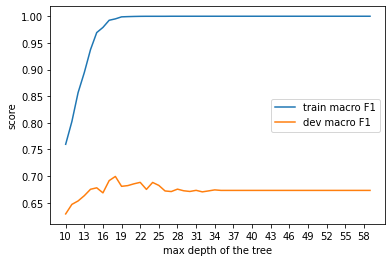

In [189]:
explore_overfitting(embedding_train_X, embedding_dev_X, embedding_train_y, embedding_dev_y)

In [203]:
def build_random_forest(X_train, y_train, n_estimators, max_depth=1):


    clf = RandomForestClassifier(random_state = 0, n_estimators=n_estimators) # create a Random Forest
    clf.fit(X_train, y_train) # train
    
   
    return clf

## Explore Overfitting

In [206]:
def explore_overfitting(X_train, X_val, y_train, y_val):
    result_train = []
    result_test = []
    for i in range(80,120, 2):
        clf = (build_random_forest(X_train, y_train, n_estimators=i)) # create model and train
        result_train.append(f1_score(clf.predict(X_train), y_train,average='macro')) 
        result_test.append(f1_score(clf.predict(X_val), y_val,average='macro')) # calcuate accuracy for test set
    # visualization
    plt.plot(range(80,120, 2), result_train, label="train macro F1")
    plt.plot(range(80,120, 2), result_test, label="dev macro F1")
    plt.xlabel("num of estimator")
    plt.ylabel("score")
    plt.legend()
    plt.xticks(range(80,120, 2))
    plt.show()

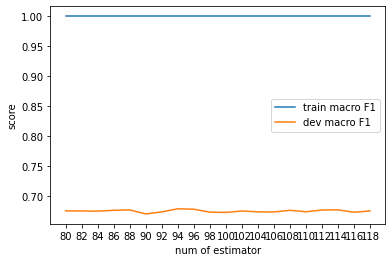

In [207]:
explore_overfitting(embedding_train_X, embedding_dev_X, embedding_train_y, embedding_dev_y)

In [32]:
clf_RF_embedding = RandomForestClassifier(n_estimators=100, max_depth=10,bootstrap='False',class_weight='balanced')
clf_RF_embedding = clf_RF_embedding.fit(embedding_train_X, train_spans_labels)
print('TRAIN:\n'+classification_report(train_spans_labels, 
                                       clf_RF_embedding.predict(embedding_train_X)))
print('dev:\n'+classification_report(dev_spans_labels,
                                      clf_RF_embedding.predict(embedding_dev_X)))

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      0.99      0.99        84
                        CaseHeader       1.00      0.98      0.99        82
                         CaseIssue       0.97      0.99      0.98        77
                          Citation       1.00      0.97      0.98       993
                   ConclusionOfLaw       0.69      0.93      0.80       168
                          Evidence       0.87      0.81      0.84      2099
EvidenceBased/Intermediate Finding       0.72      0.49      0.59       648
            EvidenceBasedReasoning       0.45      0.54      0.49       553
                            Header       0.99      0.99      0.99       716
                       LegalPolicy       0.47      0.95      0.63        80
                         LegalRule       0.85      0.80      0.82       851
              PolicyBasedReasoning       0.61      1.00      0.75        20
    

## nonlinear model -- RandomForests

### using TFIDF featurization

In [28]:
clf_RF_tfidf = RandomForestClassifier(n_estimators=140, max_depth=12,bootstrap='False',class_weight='balanced')
clf_RF_tfidf = clf_RF_tfidf.fit(tfidf_train_X, train_spans_labels)
print('TRAIN:\n'+classification_report(train_spans_labels, 
                                       clf_RF_tfidf.predict(tfidf_train_X)))
print('dev:\n'+classification_report(dev_spans_labels,
                                      clf_RF_tfidf.predict(tfidf_dev_X)))

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.97      0.99      0.98        84
                        CaseHeader       0.99      0.98      0.98        82
                         CaseIssue       0.76      1.00      0.87        77
                          Citation       0.97      0.98      0.97       993
                   ConclusionOfLaw       0.63      0.96      0.76       168
                          Evidence       0.90      0.81      0.85      2099
EvidenceBased/Intermediate Finding       0.82      0.75      0.78       648
            EvidenceBasedReasoning       0.69      0.71      0.70       553
                            Header       0.68      0.99      0.81       716
                       LegalPolicy       0.79      0.95      0.86        80
                         LegalRule       0.91      0.85      0.88       851
              PolicyBasedReasoning       0.86      0.95      0.90        20
    

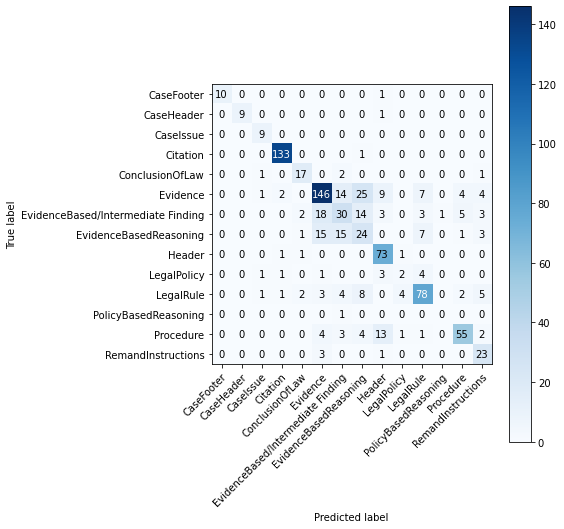

In [31]:
plot_confusion_matrix(dev_spans_labels, clf_RF_tfidf.predict(tfidf_dev_X), classes=list(clf_RF_tfidf.classes_),
                      )
plt.show()

In [258]:
def prediction_errors(clf, eval_spans, vectorizer, 
                      select_true_label=None, 
                      select_pred_label=None):
    eval_X, eval_y = make_embedding_feature_vectors_and_labels(eval_spans, vectorizer)
    eval_spans_txt = [s['txt'] for s in eval_spans]
    eval_spans_labels = [s['type'] for s in eval_spans]
    pred_y = clf.predict(eval_X)
    for i in range(len(eval_spans)):
        true_label = eval_spans_labels[i]
        pred_label = pred_y[i]
        if true_label != pred_label:
            if select_true_label and true_label != select_true_label: continue
            if select_pred_label and pred_label != select_pred_label: continue
            doc_name = dev_documents_by_id[eval_spans[i]['document']]['name']
            print('sentence # '+str(i)+' / case '+doc_name+' / @'+str(eval_spans[i]['start']))
            print('pred: '+pred_label+' / true: '+true_label)
            print(eval_spans[i]['txt'])
            print()

In [275]:
prediction_errors(clf_RF_embedding,
                  random.sample(dev_spans, 500),
                  spacy_tfidf_vectorizer,
                  select_pred_label='RemandInstructions')

sentence # 4 / case 1635686.txt / @4256
pred: RemandInstructions / true: LegalRule
On remand, the RO should also associate ongoing pertinent VA treatment reports with the record before the Board.

sentence # 51 / case 1638605.txt / @1068
pred: RemandInstructions / true: Procedure
The appeal is REMANDED to the Agency of Original Jurisdiction (AOJ).  VA will notify the appellant if further action is required.

sentence # 153 / case 1100174.txt / @11205
pred: RemandInstructions / true: EvidenceBasedReasoning
Therefore, the opinions 
provided were not given in consideration of all of the relevant 
data.

sentence # 157 / case 1638605.txt / @2693
pred: RemandInstructions / true: LegalRule
This claim must be afforded expeditious treatment.

sentence # 180 / case 1203065.txt / @24470
pred: RemandInstructions / true: EvidenceBasedReasoning
 As noted above, the examiner has medical expertise, provided supporting rationale for the opinion provided, citing to the medical evidence reviewed.  

sen

## Evaluation on dev data using best model 

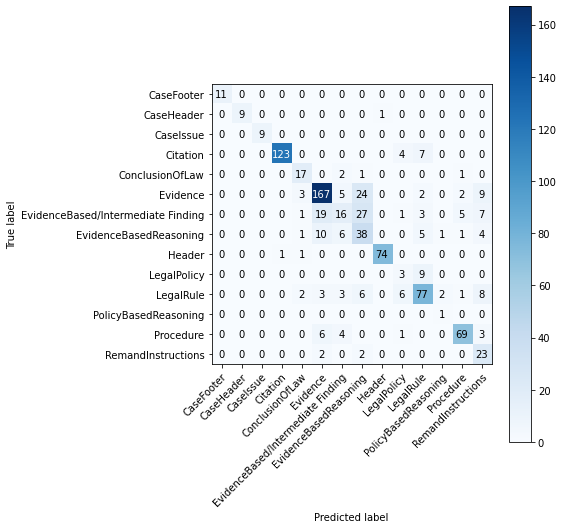

In [34]:
plot_confusion_matrix(dev_spans_labels, clf_RF_embedding.predict(embedding_dev_X), classes=list(clf_RF_embedding.classes_),
                      )
plt.show()

## Evaluation on test data using best model 

In [276]:
print('Final Test:\n'+classification_report(test_spans_labels, clf_RF_embedding.predict(embedding_test_X)))

Final Test:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      0.91      0.95        11
                        CaseHeader       0.90      1.00      0.95         9
                         CaseIssue       1.00      1.00      1.00         9
                          Citation       1.00      0.86      0.92       128
                   ConclusionOfLaw       0.62      0.87      0.72        15
                          Evidence       0.77      0.76      0.76       214
EvidenceBased/Intermediate Finding       0.46      0.37      0.41        71
            EvidenceBasedReasoning       0.18      0.27      0.22        44
                            Header       1.00      0.99      0.99        85
                       LegalPolicy       0.29      0.32      0.30        19
                         LegalRule       0.54      0.59      0.57        69
              PolicyBasedReasoning       0.00      0.00      0.00         7

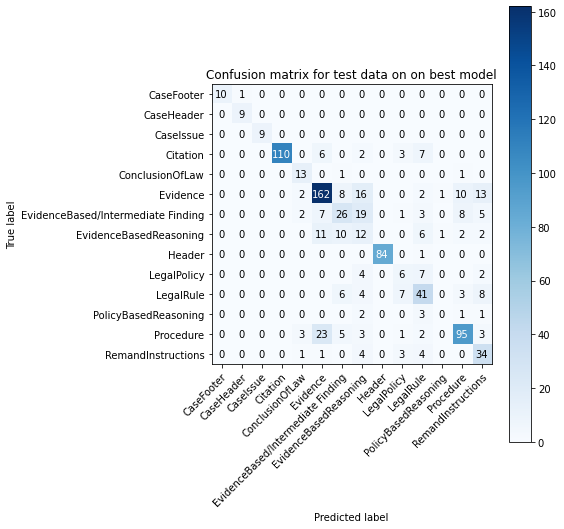

In [277]:
plot_confusion_matrix(test_spans_labels, clf_RF_embedding.predict(embedding_test_X), classes=list(clf_RF_embedding.classes_),
                      title='Confusion matrix for test data on on best model')
plt.show()

In [287]:
#save model
data_root = os.path.abspath(os.path.abspath(os.getcwd()))
best_model = os.path.join(data_root,"clf_RF_embedding.joblib")

In [288]:
dump(clf_RF_embedding, best_model) 

['/Users/xinyuezhang/Downloads/ldsi-project/ldsi_s2021/clf_RF_embedding.joblib']